In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

In [2]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [329]:
x_s = np.linspace(-4,4, 15)
y_s = np.linspace(-4,4, 15)
theta_s = np.linspace(0,2*np.pi, 15)


In [330]:
xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)

In [233]:
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T
len(grid)

3375

In [331]:
grid

array([[-4.        , -4.        ,  0.        ],
       [-4.        , -4.        ,  0.44879895],
       [-4.        , -4.        ,  0.8975979 ],
       ...,
       [ 4.        ,  4.        ,  5.38558741],
       [ 4.        ,  4.        ,  5.83438636],
       [ 4.        ,  4.        ,  6.28318531]])

In [332]:
#generate data

env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    for action in range(env.action_space.n):
        X.append(state)
        r = env.sample(state, action, 0)
        y.append(r)

X = np.array(X)
y = np.array(y)



In [34]:
env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(2000):
    state = env.reset()
    for action in range(env.action_space.n):
        X.append(state)
        r = env.sample(state, action, 0)
        y.append(r)

X = np.array(X)
y = np.array(y)

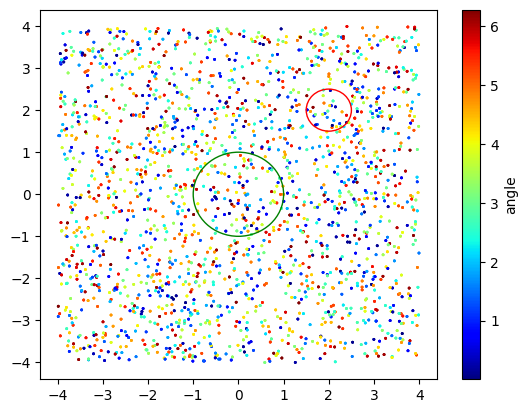

In [35]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=X[:,2], s=1) # s is a size of marker 
        # draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)

plt.jet()
plt.colorbar(label='angle')
#plt.show()
plt.savefig('env.png')

In [240]:
np.max(X[:,2])

6.2831855

In [241]:
np.min(y)

-10

In [55]:
#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(9)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(1)(l2)

    return l3.ravel()


#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(12)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(6)(l2)
#     l4 = jax.nn.relu(l3)

#     l5= hk.Linear(1)(l4)

#    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.adabelief(learning_rate=1e-1)
opt_state = optimizer.init(params)
batch_size = len(X)

#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.85)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        print("progress:", "epoch:", epoch, "loss",loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
    
    
# After training
print("estimation of the parameters:")
print(params)

estimate  = forward(X=env.reset(), params=params)
print("estimate", estimate)

progress: epoch: 0 loss 8.744543
progress: epoch: 1 loss 7.2625546
progress: epoch: 2 loss 6.5521755
progress: epoch: 3 loss 6.542024
progress: epoch: 4 loss 6.827084
progress: epoch: 5 loss 7.533665
progress: epoch: 6 loss 6.9739943
progress: epoch: 7 loss 6.1880717
progress: epoch: 8 loss 5.177934
progress: epoch: 9 loss 5.042005
progress: epoch: 10 loss 5.4637446
progress: epoch: 11 loss 6.1222415
progress: epoch: 12 loss 6.9560175
progress: epoch: 13 loss 7.2531433
progress: epoch: 14 loss 7.3418813
progress: epoch: 15 loss 7.0816655
progress: epoch: 16 loss 6.890034
progress: epoch: 17 loss 6.6306243
progress: epoch: 18 loss 6.5222025
progress: epoch: 19 loss 6.4438305
progress: epoch: 20 loss 6.3841934
progress: epoch: 21 loss 6.3135734
progress: epoch: 22 loss 6.2059245
progress: epoch: 23 loss 6.166823
progress: epoch: 24 loss 6.0402927
progress: epoch: 25 loss 6.0125613
progress: epoch: 26 loss 5.8637657
progress: epoch: 27 loss 5.8292108
progress: epoch: 28 loss 5.657988
prog

In [13]:
env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(100000):
    state = env.reset()
    X_val.append(state)

X_val = np.array(X_val)


In [56]:
y_pred = [forward(X=x, params=params) for x in X_val]

In [ ]:
max(y_pred)

Array([9.165129], dtype=float32)

: 

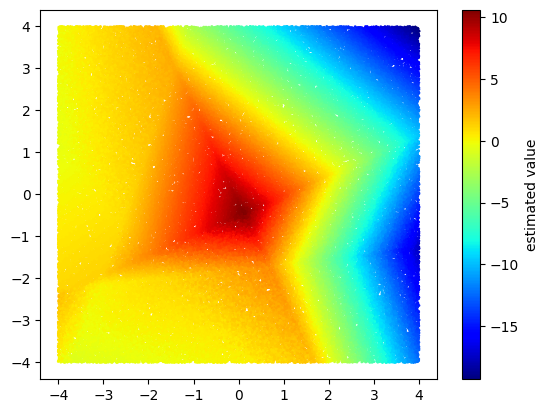

In [62]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X_val[:,0], X_val[:,1], c=y_pred, s=1) # s is a size of marker 
plt.jet()
plt.colorbar(label='estimated value')
#plt.savefig('500_iter_adabeleif_.85gamma.png')
plt.show()


In [63]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
#state = env.set(-3, -2, right)
state = env.reset()

gamma = 0.85
traj = []
done = False
max_iter = 200
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        estimate = forward(X=next_state, params=params)
        value = reward + gamma*estimate[0]
        print('estimate', value)
        print('state:',next_state)

        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    print('next_states', action, possible_actions)
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
env.make_gif()

estimate 0.98758894
state: [-2.6153035  3.0575895  4.0318727]
estimate 0.9316089
state: [-2.6153035  3.0575895  5.1663365]
estimate 1.1856724
state: [-2.6153035   3.0575895   0.01761502]
next_states 2 [Array(0.98758894, dtype=float32), Array(0.9316089, dtype=float32), Array(1.1856724, dtype=float32)]
1
estimate 1.0201356
state: [-2.515319   3.059351   5.1663365]
estimate 1.274199
state: [-2.515319    3.059351    0.01761502]
estimate 1.2182188
state: [-2.515319  3.059351  1.152079]
next_states 1 [Array(1.0201356, dtype=float32), Array(1.274199, dtype=float32), Array(1.2182188, dtype=float32)]
2
estimate 1.1086622
state: [-2.4153347  3.0611124  5.1663365]
estimate 1.3627257
state: [-2.4153347   3.0611124   0.01761502]
estimate 1.3067455
state: [-2.4153347  3.0611124  1.152079 ]
next_states 1 [Array(1.1086622, dtype=float32), Array(1.3627257, dtype=float32), Array(1.3067455, dtype=float32)]
3
estimate 1.197189
state: [-2.3153503  3.0628738  5.1663365]
estimate 1.4512525
state: [-2.3153503

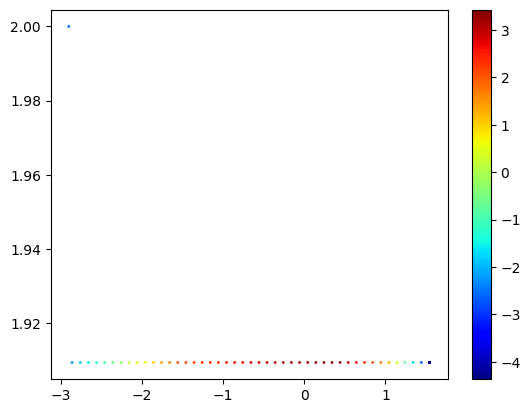

In [51]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

In [64]:
yp

[Array([-4.5030727 ,  3.474363  ,  3.984849  ,  3.5156813 ,  3.0465136 ,
         2.577344  ,  2.108175  ,  1.6390063 ,  1.1698382 ,  0.7006685 ,
         0.23149979, -0.23766923, -0.70683813, -1.1760051 , -1.6451757 ,
        -2.1143444 , -2.583513  , -3.052684  , -3.5218484 , -3.9910195 ,
        -4.5030727 ], dtype=float32)]

In [689]:
forward(X=np.array([0,0,0]), params=params) 

Array([0.23673654], dtype=float32)